## Table of Contents
- Section 1: Introduction
- Section 2: Methodology
    - Section 2.i: Convert Data
    - Section 2.ii: Optical Character Recognition
    - Section 2.iii: Create Datasets
    - Section 2.iv: Create the Model
    - Section 2.v: Model Training
- Section 3: Results

## Section 1: Introduction<a name="section-1-introduction"></a>

This notebook outlines the process to fine-tune a PyTorch model to separate documents into different categories. This model was intended to be incorporated into a data processing pipeline. Once a document was classified, additional processing would take place downstream depending on its classification.

This project uses Microsoft's LayoutLM model to classify the documents and is influenced by this [Venelin Valkov blog](https://www.mlexpert.io/blog/document-classification-with-layoutlmv3). Unlike a traditional convolution neural network, this model incorporates the text elements in the document and the spatial relationship between the text elements. This is in contrast to traditional convolution neural networks which ignores the text elements. Because of the ability to incorporoate text, LayoutLM can produce superior results for document classification than a CNN.

The goal was to incorporate a document separating model into a data processing pipeline. To that end, the goal was to fine-tune a the LayoutLM model so it could classify a document into five separate categories:
- communication: Documents that communicate information to subjects (e.g. instructions for colonscopy) contina limited research utility. Therefore, these documents were excluded from further processing and were excluded from the data registry.
- requisition_results: The results from lab tests were already captured in a structured manner. Processing the lab results did add any additional information; therefore, they were expected to not be processed any further.
- fax: Since the final model only evaluates the first page of a document, if it is determined that the first page of the document is a fax cover sheet, our pipeline will look at the second page to determine how the document is processed.
- medical_image: It was anticipated that there would be requests to access medical images in the near future; therefore, we need to identify the medical images to segregate them for further use.
- other: All other documents were considered relevant and would be further processed including extracting the data using optical character recognition and natural language processing.

## Section 2: Methodology<a name="section-2-methodology"></a>

### Section 2.i: Convert Data<a name="section-2i-data"></a>

The data collected for this project exists in three different forms: PDFs, TIFs, and JPGs. For the model to work, we need to use a single file format. Therefore, it is necessary to convert the PDFs and TIFs into JPGs. To that end, we create two functions `convert_tif_image` and `convert_pdf_image`.

In [1]:
from PIL import Image
import pypdfium2 as pdfium

def convert_tif_image(file_path):
    """Convert first page of TIF file to PIL Image

    Parameters
    ----------
    file_path : str
        Path to location of TIF file

    Returns
    -------
    PIL.Image
    """

    try:
        im = Image.open(file_path)

        if im.n_frames > 1:
            im.seek(0)
        return im

    except Exception as e:
        print (e)

def convert_pdf_image(file_path):
    """Convert first page of PDF file to PIL Image

    Parameters
    ----------
    file_path : str
        Path to location of PDF file

    Returns
    -------
    PIL.Image
    """
    try:
        pdf = pdfium.PdfDocument(file_path)
        first_page = pdf[0]
        return first_page.render(scale=4).to_pil()
    except Exception as e:
        print (e)

Once we have functions to convert the pdfs and tifs into image files, we can convert our files. After conversion, all files in the `processed` folder only contain jpg images.

In [2]:
import shutil
import os

for root, _, files in os.walk('../data/raw', topdown=False):
    for file in files:
        
        if file.lower().endswith('.pdf'):
            img = convert_pdf_image(os.path.join(root, file))
            img.save(
                os.path.join(
                    root.replace('raw', 'processed'), file.lower().replace('.pdf', '.jpg')
                )
            )
        elif file.endswith(('.jpg', '.jpeg')):
            shutil.copy2(
                os.path.join(root, file), 
                os.path.join(root.replace('raw', 'processed'), file.replace('.jpeg', '.jpg'))
            )
        elif file.lower().endswith('.tif'):
            img = convert_tif_image(os.path.join(root, file))
            img.save(
                os.path.join(
                    root.replace('raw', 'processed'), file.lower().replace('.tif', '.jpg')
                )
            )

### Section 2.ii: Optical Character Recognition<a name="section-2ii-ocr"></a>

Layout LM combines the text with the text location and other image features to help classify the document.

Optical character recognition (OCR) is used to extract the text from the documents, if applicable. The default Layout LM OCR is Google's Tesseract which can be relatively slow to extract the text. Here we use an alternative OCR package, `easyocr`, to extract text from the images and the function `create_bounding_box` to organize the text location information. The text and associated location information is extracted and saved as a json file which we will use in for training.

In [3]:
import json
import easyocr

def create_bounding_box(bbox_data):
    """Simplify bounding box from corner box

    Bounding box data has x and y coordinates for each corner of the box 
    (i.e. 8 coordinates total). The coordinates can be reduced to a single 
    value for left, right, top and bottom because of the repeative nature 
    of some values.

    Parameters
    ----------
    bbox_data : List of List
        Contains X, Y coordinates for each corner of the box

    Returns
    -------
    List
        Contents are a single value for left, right, top and bottom
    """
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)
    
    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

reader = easyocr.Reader(['en'])

# get OCR info and save as a json file
for root, _, files in os.walk('../data/processed', topdown=False):
    for file in files:

        ocr_result = reader.readtext(os.path.join(root, file), batch_size=16)

        ocr_page = []
        for bbox, word, confidence in ocr_result:
            ocr_page.append({
                "word": word, "bounding_box": create_bounding_box(bbox)
            })
        
        with open(os.path.join(root, file).replace('.jpg', '.json'), 'w') as f:
            json.dump(ocr_page, f)

/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


### Section 2.iii: Create Datasets<a name="section-2iii-dataset"></a>

We have our images, labels (via file), text, and absolute location information. We need to combine all the information into a dataset that can be consumed using by our model.

The `DOCUMENT_CLASSES` object will be used to label our data.

In [4]:
DOCUMENT_CLASSES = [
    'communication', 'fax', 'medical_image', 'other', 'requisition_results'
]

When we obtain and organize the text location information using `easyocr` and `create_bounding_box`, the location information is absolute. Since the images are different sizes, we need to convert the image location information from absolute to relative. The function `scale_bounding_box` makes the conversion.

In [5]:
def scale_bounding_box(
    box, width_scale = 1.0, height_scale = 1.0
):
    """Scale bounding box

    Parameters
    ----------
    box : List
        List containing bounding box coordinates
    width_scale : float, optional
        Value in which to rescale the width of box, by default 1.0
    height_scale : float, optional
        Value in which to rescale the height of box, by default 1.0

    Returns
    -------
    List
        Values associated with rescaled bounding box
    """
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

The class `DocumentClassificationDataset` will open and process the data set (images and json) it can be consumed by the model. The data will eventually be processed by our model's processor (`LayoutLMv3ImageProcessor`). The processor has default functions to resize, normalize, and extract text; however, we have done most of this ourselves.

In [6]:
import re
import torch
from torch.utils.data import Dataset

class DocumentClassificationDataset(Dataset):

    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor
  
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):

        image_path = self.image_paths[item]
        json_path = image_path.replace('.jpg', '.json')
        
        with open(json_path, 'r') as f:
            ocr_result = json.load(f)
        
            with Image.open(image_path).convert("RGB") as image:
                # relative size parameters
                width, height = image.size
                width_scale = 1000 / width
                height_scale = 1000 / height
        
                words = []
                boxes = []
                for row in ocr_result:
                    boxes.append(
                        scale_bounding_box(
                            row["bounding_box"],
                            width_scale,
                            height_scale
                        )
                    )
                    words.append(row["word"])

                encoding = self.processor(
                    image, 
                    words,
                    boxes=boxes,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
        
        # get the label from the folder structure
        string_label = re.sub(
            '/.*jpg$', 
            '', 
            re.sub(
                '../data/processed/(train|validation)/', 
                '', 
                image_path
            )
        )
        label = DOCUMENT_CLASSES.index(string_label)

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            bbox=encoding["bbox"].flatten(end_dim=1),
            pixel_values=encoding["pixel_values"].flatten(end_dim=1),
            labels=torch.tensor(label, dtype=torch.long)
        )

`DocumentClassificationDataset` will organize and process our data but we need to pass it the images and text info via the file paths so it knows what data to process. We create a function `get_file_paths` to accomplish organize all relevant file paths.

In [7]:
def get_file_paths(set_type):
    """Get file paths associated with a file type

    Parameters
    ----------
    set_type : str
        Data set type associated with folder structure (i.e. train, validation, test)

    Returns
    -------
    List
        Contains all file paths associated with a data set of interest
    """
    file_paths = []
    for root, _, files in os.walk('../data/processed/' + set_type, topdown=False):
        for file in files:
            if file.endswith('.jpg'):
                file_paths.append(os.path.join(root, file))

    return file_paths

train_paths = get_file_paths('train')
val_paths = get_file_paths('validation')

We need to designate a model specific processor which includes an image processor and a tokenizer. As previously mentioned, we will override most of the image processor's (`LayoutLMv3ImageProcessor`) default functions; however, we still need the Layout LM tokenizer (`LayoutLMv3TokenizerFast`) to perform text and location tasks such as tokenization and applying attention masks. With all the components, we can create a training and validation data set.

In [8]:
from transformers import LayoutLMv3ImageProcessor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from torch.utils.data import DataLoader

image_processor = LayoutLMv3ImageProcessor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(
    image_processor=image_processor, tokenizer=tokenizer
)

train_dataset = DocumentClassificationDataset(train_paths, processor)
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=3
)

val_dataset = DocumentClassificationDataset(val_paths, processor)
val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=3
)

/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Section 2.iv: Create the Model<a name="section-2iv-create-model"></a>

We need to create a PyTorch model to train. In this case, we are fine-tuning Microsoft's Layout LM and most of the model's details are abstracted; however, we still need to configure the model so it can use our data appropriately. We use PyTorch Lightning to help organize the boilerplate code.

In [9]:
import lightning as L
from torchmetrics import Accuracy

class ModelModule(L.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=n_classes
        )
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
 
    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )
 
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log(
            "train_acc",
            self.train_accuracy(output.logits, labels),
            on_step=True,
            on_epoch=True
        )
        return output.loss
 
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log(
            "val_acc",
            self.val_accuracy(output.logits, labels),
            on_step=False,
            on_epoch=True,
            prog_bar=True
        )
        
        return output.loss
 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001)
        return optimizer

### Section 2.v: Train the Model<a name="section-2v-train-model"></a>

We have already created the datasets. We need to create an instance of the model class (`ModelModule`), and a trainer (`Trainer`) to train the model.

In [10]:
model_module = ModelModule(len(DOCUMENT_CLASSES))

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We create a trainer which incorporates two callbacks into our training. We use `ModelCheckpoint` to save a copy of our model after each epoch.

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(
    dirpath='../models/',
    filename="{epoch}-{step}-{val_loss:.4f}",
    save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)

trainer = L.Trainer(
    accelerator="gpu", 
    precision="16-mixed",
    max_epochs=10,
    callbacks=[
        model_checkpoint,
        EarlyStopping(monitor="val_loss", mode="min", patience=2)
    ]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


We now have everything we need and we can train the model.

In [12]:
trainer.fit(model_module, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                                | Params
-----------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M 
1 | train_accuracy | MulticlassAccuracy                  | 0     
2 | val_accuracy   | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
503.686   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 6: 100%|██████████| 45/45 [01:25<00:00,  0.52it/s, v_num=0, val_acc=0.840]


## Section 3: Results<a name="section-3-results"></a>
Once we have a final model, we can load the test files to get our model accuracy.

In [13]:
import pandas as pd
pd.read_csv("lightning_logs/version_0/metrics.csv")

,epoch,step,train_acc_epoch,train_acc_step,train_loss,val_acc,val_loss
0,0,44,NaN,NaN,NaN,0.60,1.053940
1,0,44,0.458101,NaN,NaN,NaN,NaN
2,1,49,NaN,0.75,0.981445,NaN,NaN
3,1,89,NaN,NaN,NaN,0.80,0.682976
4,1,89,0.782123,NaN,NaN,NaN,NaN
5,2,99,NaN,1.00,0.304016,NaN,NaN
6,2,134,NaN,NaN,NaN,0.80,0.588947
7,2,134,0.927374,NaN,NaN,NaN,NaN
8,3,149,NaN,1.00,0.214523,NaN,NaN
9,3,179,NaN,NaN,NaN,0.76,0.583840


As a result of the early stopping callback, not all 10 epochs were completed since the validation loss was no longer decreasing. We can see from epoch 4 that the model had a 99% accuracy on the training data set and a 88% accuracy on the validation data set. The model starts overfitting the data on the 5 and 6 epochs.

We can create a confusion matrix to determine the accuracy of our trained model. The test or holdout dataset contains images, text, and location data which the model has not seen as part of the training or validation and therefore gives an idea of the real world performance of the model. In order to test the fine-tuned model, we need to first load and configure it for inference/evaluation.

In [14]:
trained_model = ModelModule.load_from_checkpoint(
    model_checkpoint.best_model_path,
    n_classes=len(DOCUMENT_CLASSES),
    local_files_only=True
)
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

model = trained_model.eval().to(DEVICE)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The function `predict_document_image` performs a similar role to the `DocumentClassificationDataset` class. The difference is that `predict_document_image` will predict the label based on the image whereas `DocumentClassificationDataset` is used for training and is provided with the label.

In [15]:
def predict_document_image(
    image_path, model, processor
):
    """Classify documents

    Parameters
    ----------
    image_path : str
        Location of documents to classify
    model : LayoutLMv3ForSequenceClassification
        Model that used to classify documents
    processor : LayoutLMv3Processor
        Associated processor to process images and tokenize words
    
    Returns
    -------
    Predicted class label

    """
    json_path = image_path.replace('.jpg', '.json')        
    with open(json_path, 'r') as f:
        
        ocr_result = json.load(f)
 
        with Image.open(image_path).convert("RGB") as image:
 
            width, height = image.size
            width_scale = 1000 / width
            height_scale = 1000 / height
 
            words = []
            boxes = []
            for row in ocr_result:
                boxes.append(
                    scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    )
                )
                words.append(row["word"])
 
            encoding = processor(
                image,
                words,
                boxes=boxes,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
 
    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )
 
    predicted_class = output.logits.argmax()

    return DOCUMENT_CLASSES[predicted_class.item()]

<!-- This function takes an image path as input, opens the image, extracts the OCR, scales the bounding boxes based on the image size, and preprocesses the image and text data using the previously defined processor. The preprocessed data is then sent to the model for inference on the GPU. Finally, the function returns the predicted class label for the input image. -->

We can now execute the function on all test documents. The `labels` holds the ground truth while predictions are stored in `predictions`.

In [16]:
test_paths = get_file_paths('test')

labels = []
predictions = []

for image_path in test_paths:
    string_label = re.sub('/.*jpg$', '', re.sub('../data/processed/test/', '', image_path))
    labels.append(string_label)
    
    predictions.append(
        predict_document_image(image_path, model, processor)
    )

/home/ryan/Documents/GitHub/obri-document-classifier/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


With the prediction and the ground truth labels, we can create a confusion matrix to gauge the accuracy of our model.

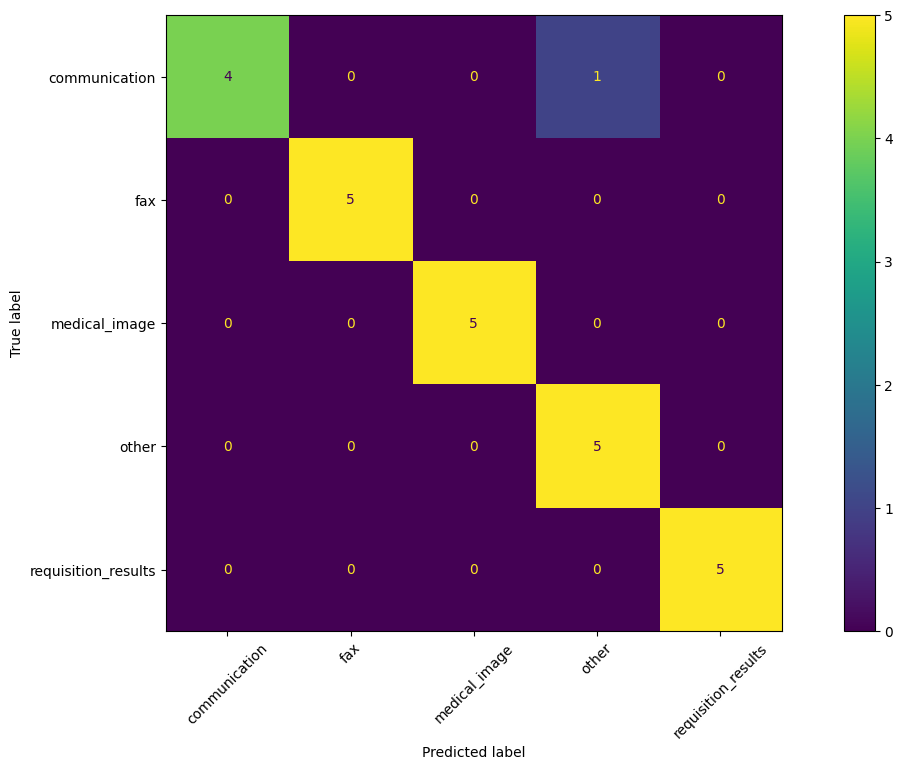

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)
 
cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)
 
plt.show()

From the confusion matrix, we can see that the model correctly identified 24 out of the 25 documents. We now have a fine tuned LayoutLMv3 model that can identify medical documents with a 96% accuracy. 